In [2]:
%matplotlib inline

In [3]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model by declaring a Base using `automap_base()`
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Display the first row's columns and data in dictionary format for Measurement
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fca9254c040>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [12]:
# Display the first row's columns and data in dictionary format for Station
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fca94044640>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = (
    session #take the session we've opened
    .query(Measurement) #Look in the Measurement dataset
    .order_by(Measurement
              .date #Order by date
              .desc()) #In decending order
    .first() #Pull the first row
    .date) #Take the value in the "date" column

recent_date

'2017-08-23'

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
last_date = ((
    dt #Using datetime module
    .datetime #retrieve datetime object

# Starting from the most recent data point in the database. 
    .strptime(recent_date, '%Y-%m-%d') #grab the recent date as a string in '%Y-%m-%d'format

# Calculate the last date one year from the most recent date in data set.
    - #subtract
    dt
    .timedelta(days=365)) #365 days from it
    .strftime('%Y-%m-%d')) #put the result in '%Y-%m-%d' format

last_date

# Perform a query to retrieve the data and precipitation scores
last_year_data = (
    session
    .query(Measurement.date, Measurement.prcp) #query the measurement date and precipitation columns
    .filter(Measurement.date >= last_date) #only keep dates that are greater than or equal to last_date
    .all()) #grab everything that matches the filter

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_data = pd.DataFrame(last_year_data, columns=["Date","Precipitation"]).set_index('Date').dropna()

# Sort the dataframe by date
last_year_data.sort_index()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


Text(0, 0.5, 'Precipitation')

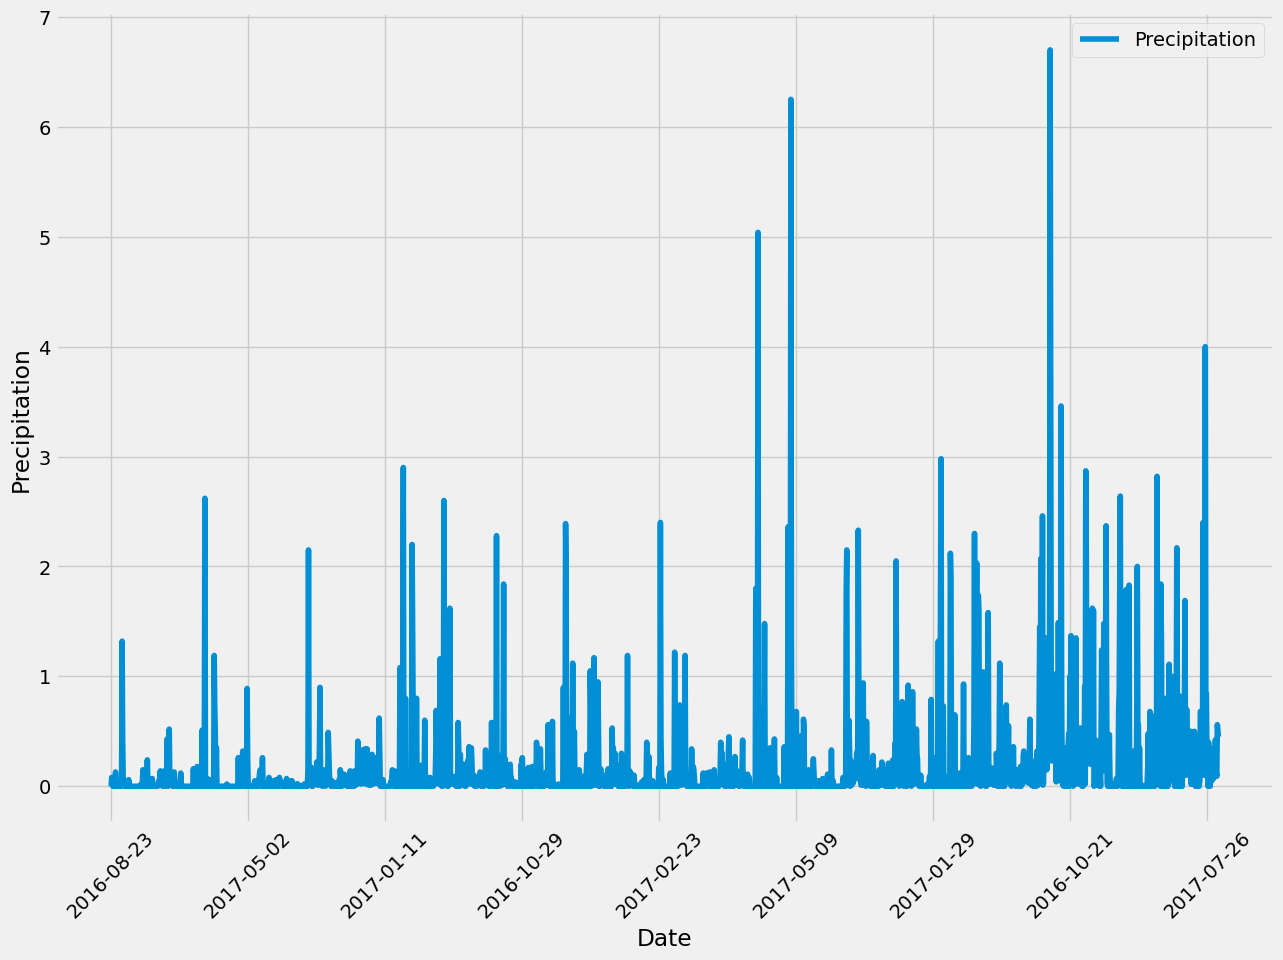

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
bar1 = last_year_data.plot(rot=45, figsize=(14,10))

plt.ylabel("Precipitation")

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()


9

In [18]:
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fca9561c3a0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [19]:
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fca954cab50>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
(
session
 .query(*[Station.station, func.count(Measurement.station)])
 .filter(Station.station == Measurement.station)
 .group_by(Station.station)
 .order_by(func
           .count(Measurement.station)
           .desc())
.all()
)


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, Measurement.date, Measurement.tobs]

temp_data = (session
             .query(*sel)
             .filter(Measurement.station == 'USC00519281')
             .all())

temp_data = pd.DataFrame(temp_data, columns=["Station","Date","Temperature"]).dropna()

print(f'''
The lowest temperature is {round(temp_data['Temperature'].min(), 1)}
The highest temperature is {round(temp_data['Temperature'].max(), 1)}
The average temperature is {round(temp_data['Temperature'].mean(), 1)}
''')


The lowest temperature is 54.0
The highest temperature is 85.0
The average temperature is 71.7



Text(0.5, 0, 'Temperature (°F)')

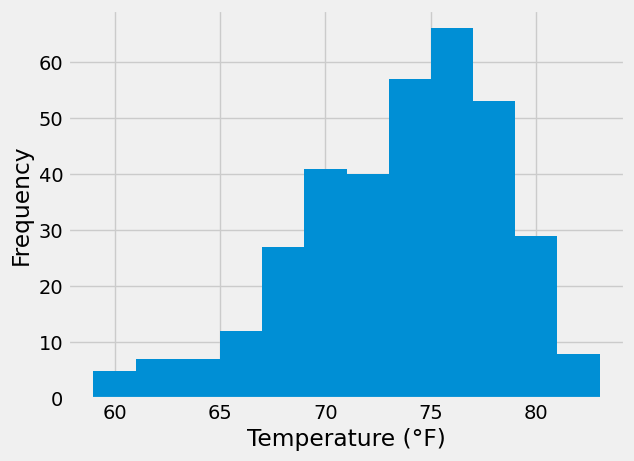

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
last_year_temp = temp_data.loc[temp_data["Date"] >= '2016-08-23']
last_year_temp

#And plot the results as a histogram
last_year_temp.plot.hist(bins=12, legend=False)
plt.xlabel('Temperature (°F)')

# Close session

In [123]:
# Close Session
session.close()